In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, f1_score, accuracy_score, precision_score, recall_score
from tabulate        import tabulate
from sklearn.preprocessing import StandardScaler

/home/elenasofiamangola/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Can a computer learn if we're going to detect gravitational waves?**
All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.


In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')
keys=f.keys()
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [3]:
# components
chi1x = f['chi1x'][::1000]
chi1y = f['chi1y'][::1000]
chi1z = f['chi1z'][::1000]
chi2x = f['chi2x'][::1000]
chi2y = f['chi2x'][::1000]
chi2z = f['chi2x'][::1000]
dec = f['dec'][::1000]
iota = f['iota'][::1000]
mtot = f['mtot'][::1000]
psi = f['psi'][::1000]
q = f['q'][::1000]
ra = f['ra'][::1000]
z = f['z'][::1000]
# label
snr = f['snr'][::1000]
det = f['det'][::1000]

In [4]:
components = np.array([chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,iota,mtot,psi,q,ra,z]).T

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(components, det, test_size=0.3)

First of all, I want to try using all the components. <br>
Let's try with a **Random Forest**. <br>
To determine which is the best depth I use cross-validation.

In [6]:
kf    = KFold(n_splits=3, shuffle=True)
# depth = how many split each decision tree can have
depth = np.linspace(1, 30, 30, dtype=int)
# n_estimators = number of trees
model_rf = RandomForestClassifier(n_estimators=100)
grid     = GridSearchCV(model_rf, param_grid={'max_depth': depth}, cv=kf)
grid.fit(xtrain, ytrain)
best_rf  = grid.best_params_['max_depth']
print(best_rf)

17


In [7]:
model_rf_best = RandomForestClassifier(n_estimators=100, max_depth=best_rf)
model_rf_best.fit(xtrain, ytrain)
ypred = model_rf_best.predict(xtest)

In [8]:
accuracy  = accuracy_score(ytest, ypred)
precision = precision_score(ytest, ypred)
recall    = recall_score(ytest, ypred)
print('Accuracy = ', accuracy)
print('Precision (purity) = ', precision)
print('Completeness (recall)= ', recall)

Accuracy =  0.963
Precision (purity) =  0.9123456790123456
Completeness (recall)=  0.8303370786516854


What I did right now was to use all the components, but maybe I don't need all of them. <br>
I run a PCA reduction to see what are the major components that have the most variance of the data (with scree plots), and I will then only use them to see if something change in the Random Forest.

In [10]:
n_features = len(components[0])
pca = PCA(n_components = n_features, whiten=True)
# PCS is sensitive to the scale of features, so I normalize them
scaler = StandardScaler()
scaled_components = scaler.fit_transform(components)
pca.fit(scaled_components) 
evals = pca.explained_variance_ratio_

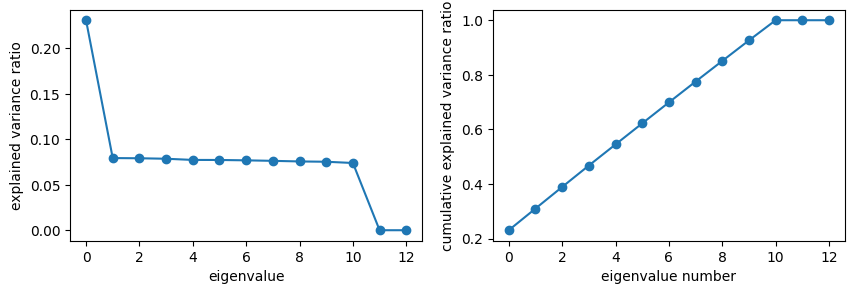

In [11]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(np.arange(n_features), evals)
ax.scatter(np.arange(n_features), evals)

ax.set_xlabel('eigenvalue')
ax.set_ylabel('explained variance ratio')

ax = fig.add_subplot(122)

ax.plot(np.arange(n_features), evals.cumsum())
ax.scatter(np.arange(n_features), evals.cumsum())

ax.set_xlabel('eigenvalue number')
ax.set_ylabel('cumulative explained variance ratio')

plt.show()

In [12]:
print(evals)

[2.30802269e-01 7.92989190e-02 7.90871319e-02 7.85590960e-02
 7.72552582e-02 7.72057914e-02 7.67982881e-02 7.62495335e-02
 7.55954435e-02 7.52588904e-02 7.38893792e-02 3.90107091e-33
 4.12872745e-36]


Basically, all the dataset can be explained using only one principal component!

In [13]:
# get the weight matrix that tells me the relationship betewwn each principal components and my physical components
# RB each PC is a linear combination of the physical components
loadings  = pca.components_
first_PC  = loadings[0:4]
row_names = ['chi1x','chi1y','chi1z','chi2x','chi2y','chi2z','dec','iota','mtot','psi','q','ra','z']
tabella_ = [[row_names[i], first_PC[0][i], first_PC[1][i], first_PC[2][i], first_PC[3][i]] for i in range(len(row_names))]
headers   = ['Feature', 'PC1', 'PC2', 'PC3', 'PC4']
tabulate(tabella_, headers=headers, tablefmt='html')

Feature,PC1,PC2,PC3,PC4
chi1x,0.00894952,-0.0529914,-0.0643363,-0.406364
chi1y,0.00342396,-0.133384,-0.515603,0.114182
chi1z,-0.00251378,0.120378,0.0337794,-0.579779
chi2x,0.577288,0.00192233,0.00336965,0.000247641
chi2y,0.577288,0.00192233,0.00336965,0.000247641
chi2z,0.577288,0.00192233,0.00336965,0.000247641
dec,0.00597785,0.191998,-0.170693,0.438154
iota,0.00336178,0.096077,-0.346704,-0.227457
mtot,-0.00124307,0.524986,-0.322154,0.14576
psi,-0.00343563,0.656192,0.0118085,0.108839


Now, I can try to do classification using only the principal components that gave me at leat 95% of variance.

In [14]:
# i want to retrain only one principal component
pca = PCA(n_components = 0.95, whiten=True)
pca.fit(scaled_components)
# I project my training dataset on the principal component axis
x_scaled_train = scaler.fit_transform(xtrain)
x_scaled_test  = scaler.transform(xtest)
x_pca_train  = pca.transform(x_scaled_train)
x_pca_test   = pca.transform(x_scaled_test)
# now I train again the random forest
model_rf_pca = RandomForestClassifier(n_estimators=100)
model_rf_pca.fit(x_pca_train, ytrain) 
ypred_pca = model_rf_pca.predict(x_pca_test)

In [15]:
accuracy_pca  = accuracy_score(ytest, ypred_pca)
precision_pca = precision_score(ytest, ypred_pca)
recall_pca    = recall_score(ytest, ypred_pca)
print('Accuracy = ', accuracy_pca)
print('Precision (purity) = ', precision_pca)
print('Completeness (recall)= ', recall_pca)

Accuracy =  0.9186666666666666
Precision (purity) =  0.8694852941176471
Completeness (recall)=  0.5314606741573034


In [16]:
metrics_  = np.array([[accuracy, precision, recall],[accuracy_pca, precision_pca, recall_pca]])
col_names = ['accuracy', 'precision', 'completeness']
row_names = ['all features', '95% var - PCA']
tabella_  = [[col] + list(row) for col, row in zip(row_names, metrics_)]
headers   = [''] + col_names
tabulate(tabella_, headers=headers, tablefmt='html')

,accuracy,precision,completeness
all features,0.963,0.912346,0.830337
95% var - PCA,0.918667,0.869485,0.531461
